In [ ]:
import sys

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
priceData = pd.read_csv('melb_data.csv')


#encode the categorical variables

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
priceData['encoded_suburb'] = encoder.fit_transform(priceData['Suburb'])
priceData['encoded_type'] = encoder.fit_transform(priceData['Type'])
priceData['encoded_sellerG'] = encoder.fit_transform(priceData['SellerG'])
priceData['encoded_councilarea'] = encoder.fit_transform(priceData['CouncilArea'])
priceData['encoded_regionname'] = encoder.fit_transform(priceData['Regionname'])



scaler = MinMaxScaler()
priceData['scaled_price'] = scaler.fit_transform(priceData[['Price']])


#impute missing values for Car, Landsize, BuildingArea, YearBuilt, CouncilArea
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

imputer0 = KNNImputer()
imputer1 = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer2 = SimpleImputer(missing_values=np.nan, strategy='median')
imputer3 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

priceData[['Car']] = imputer2.fit_transform(priceData[['Car']])
priceData[['Landsize']] = imputer1.fit_transform(priceData[['Landsize']])
priceData[['BuildingArea']] = imputer0.fit_transform(priceData[['BuildingArea']])
priceData[['YearBuilt']] = imputer0.fit_transform(priceData[['YearBuilt']])
priceData[['CouncilArea']] = imputer3.fit_transform(priceData[['CouncilArea']])



Using TensorFlow backend.


In [ ]:
priceData.describe()

In [ ]:
#Using Pearson Correlation
plt.figure(figsize = (20,15))
cor = priceData.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

In [ ]:
#figure out which variables contain missing data
priceData.isnull().sum()

#figure out relevant features, correlation > 0.2
cor_target = abs(cor["Price"])
selected_features = cor_target[cor_target>0.2]
selected_features

<AxesSubplot:xlabel='Rooms', ylabel='Price'>

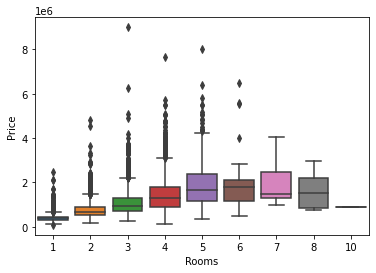

In [51]:
sns.boxplot(data = priceData, x='Rooms', y='Price')


<AxesSubplot:xlabel='Rooms', ylabel='Price'>

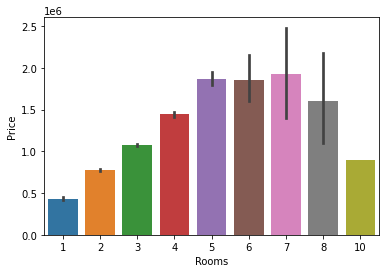

In [50]:
sns.barplot(data = priceData, x='Rooms', y='Price')

In [3]:
#prepare data for the model based on selected features

x = priceData[['Rooms', 'Bedroom2', 'Bathroom','Car', 'YearBuilt', 'Lattitude', 'Longtitude', 'encoded_type']].copy()
y = priceData[['scaled_price']].copy()

#split into train and test 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 1)

#scale the data
x_train = scaler.fit_transform( x_train )
y_train = scaler.fit_transform( y_train )

### DNN Regressor

In [5]:
#develop a deep neural net model

def create_model(neurons=1, dropout_rate=0.0, learn_rate=0.01):
    model = Sequential()
    model.add(Dense(13, input_dim=8, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

dnnreg = KerasRegressor(build_fn=create_model, verbose=0)


In [15]:

batch_size = [20, 40, 60]
epochs = [10, 50]
neurons = [16, 32, 40]
dropout_rate = [0.0, 0.1, 0.2, 0.3]
learn_rate = [0.001, 0.01, 0.1]

param_grid = dict(batch_size=batch_size, epochs=epochs, neurons = neurons,dropout_rate = dropout_rate, learn_rate=learn_rate)
search = RandomizedSearchCV(estimator=dnnreg, param_distributions=param_grid, n_jobs=-1, cv=3, scoring = "neg_mean_absolute_error")
search_resultReg = search.fit(x_train, y_train)
print("Best: %f using %s" % (search_resultReg.best_score_, search_resultReg.best_params_))

means = search_resultReg.cv_results_['mean_test_score']
stds = search_resultReg.cv_results_['std_test_score']
params = search_resultReg.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: -0.028691 using {'neurons': 40, 'learn_rate': 0.01, 'epochs': 50, 'dropout_rate': 0.0, 'batch_size': 20}
-0.032622 (0.000685) with: {'neurons': 16, 'learn_rate': 0.01, 'epochs': 50, 'dropout_rate': 0.3, 'batch_size': 60}
-0.028691 (0.000529) with: {'neurons': 40, 'learn_rate': 0.01, 'epochs': 50, 'dropout_rate': 0.0, 'batch_size': 20}
-0.031598 (0.001823) with: {'neurons': 32, 'learn_rate': 0.001, 'epochs': 50, 'dropout_rate': 0.0, 'batch_size': 60}
-0.030096 (0.000525) with: {'neurons': 16, 'learn_rate': 0.01, 'epochs': 50, 'dropout_rate': 0.1, 'batch_size': 60}
-0.048371 (0.013170) with: {'neurons': 32, 'learn_rate': 0.001, 'epochs': 10, 'dropout_rate': 0.1, 'batch_size': 60}
-0.029838 (0.000591) with: {'neurons': 16, 'learn_rate': 0.001, 'epochs': 50, 'dropout_rate': 0.0, 'batch_size': 60}
-0.033846 (0.002484) with: {'neurons': 32, 'learn_rate': 0.01, 'epochs': 10, 'dropout_rate': 0.1, 'batch_size': 40}
-0.032157 (0.001068) with: {'neurons': 32, 'learn_rate': 0.1, 'epochs': 10

In [ ]:
import joblib 

joblib.dump(search_resultReg, 'DNNregressor.pkl')

In [ ]:
batch_size = [20, 40, 60]
epochs = [10, 50]
neurons = [16, 32, 40]
dropout_rate = [0.0, 0.1, 0.2, 0.3]
learn_rate = [0.001, 0.01, 0.1]

param_grid = dict(batch_size=batch_size, epochs=epochs, neurons = neurons,dropout_rate = dropout_rate, learn_rate=learn_rate)
search = RandomizedSearchCV(estimator=dnnreg, param_distributions=param_grid, n_jobs=-1, cv=3)
search_resultReg = search.fit(x_train, y_train)
print("Best: %f using %s" % (search_resultReg.best_score_, search_resultReg.best_params_))

means = search_resultReg.cv_results_['mean_test_score']
stds = search_resultReg.cv_results_['std_test_score']
params = search_resultReg.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


In [16]:
search_resultReg.score(x_train, y_train)


-0.030424975838875563

In [8]:
kfold5 = KFold(n_splits=5, random_state=1, shuffle=True)                        
dnn_tuned = KerasRegressor(build_fn=create_model, verbose=0, epochs = 50, batch_size = 20, learn_rate = 0.01)

dnn_tuned.fit(x_train, y_train)

In [19]:

MAE_dnn = cross_val_score(dnn_tuned, x, y, scoring='neg_mean_absolute_error',cv = kfold5, n_jobs=-1)
RMSE_dnn = cross_val_score(dnn_tuned, x, y, scoring='neg_root_mean_squared_error',cv = kfold5, n_jobs=-1)
MSE_dnn = cross_val_score(dnn_tuned, x, y, scoring='neg_mean_squared_error',cv = kfold5, n_jobs=-1)
Rsquared_dnn = cross_val_score(dnn_tuned, x, y, scoring='r2',cv = kfold5, n_jobs=-1)



In [20]:
MAE_dnn
RMSE_dnn
MSE_dnn
Rsquared_dnn

array([-28.36267061,   0.14554767, -14.48806062,  -5.29271992,
        -2.5523601 ])

### Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# define the model
RFmodel = RandomForestRegressor()

#fit the model on training data
RFmodel.fit(x_train, y_train.ravel())


# make a prediction on test data
rf_pred = RFmodel.predict(x_test)
MSE = mean_squared_error(y_test, rf_pred)

In [16]:
#parameter tuning with randomsearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


# Random search of parameters, using 3 fold cross validation, 
# search across 50 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = RFmodel, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random = rf_random.fit(x_train, y_train.ravel())

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [20]:
rf_random.best_params_


{'n_estimators': 1500,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': True}

In [16]:
rf_tuned = RandomForestRegressor(n_estimators = 566,
 min_samples_split = 5,
 min_samples_leaf = 2,
 max_depth = None,
 bootstrap= True)

In [22]:
rf_random.score(x_train, y_train)


0.9252415208581706

In [17]:
MAE_rf = cross_val_score(rf_tuned, x, y, scoring='neg_mean_absolute_error',cv = kfold5, n_jobs=-1)
RMSE_rf = cross_val_score(rf_tuned, x, y, scoring='neg_root_mean_squared_error',cv = kfold5, n_jobs=-1)
MSE_rf = cross_val_score(rf_tuned, x, y, scoring='neg_mean_squared_error',cv = kfold5, n_jobs=-1)
Rsquared_rf = cross_val_score(rf_tuned, x, y, scoring='r2',cv = kfold5, n_jobs=-1)



In [18]:
MAE_rf
RMSE_rf
MSE_rf
Rsquared_rf

array([0.76583975, 0.70052481, 0.76869645, 0.74369833, 0.73968698])

In [21]:
import joblib
joblib.dump(rf_random, 'Randomforestregressor.pkl')

['Randomforestregressor.pkl']

### KNN Regression

In [23]:
from sklearn.neighbors import KNeighborsRegressor


In [24]:
# Select an algorithm
knn = KNeighborsRegressor()
hp_candidates = [{'n_neighbors': [2,3,4,5,6], 'weights': ['uniform','distance']}]
knngrid = GridSearchCV(estimator=knn, param_grid=hp_candidates, cv=3, n_jobs=-1)
knngrid = knngrid.fit(x_train, y_train)


In [25]:
# Get the results
print(knngrid.best_score_)
print(knngrid.best_estimator_)
print(knngrid.best_params_)

0.6498249117739794
KNeighborsRegressor(n_neighbors=6, weights='distance')
{'n_neighbors': 6, 'weights': 'distance'}


In [24]:
knn_tuned = KNeighborsRegressor(n_neighbors=6, weights='distance')

In [27]:
MAE_knn = cross_val_score(knn_tuned, x, y, scoring='neg_mean_absolute_error',cv = kfold5, n_jobs=-1)
RMSE_knn = cross_val_score(knn_tuned, x, y, scoring='neg_root_mean_squared_error',cv = kfold5, n_jobs=-1)
MSE_knn = cross_val_score(knn_tuned, x, y, scoring='neg_mean_squared_error',cv = kfold5, n_jobs=-1)
Rsquared_knn = cross_val_score(knn_tuned, x, y, scoring='r2',cv = kfold5, n_jobs=-1)


In [28]:
MAE_knn
RMSE_knn
MSE_knn
Rsquared_knn

array([0.5503502 , 0.50135989, 0.53736171, 0.48192004, 0.50364643])

In [26]:
joblib.dump(knngrid, 'KNNgridregressor.pkl')

['KNNgridregressor.pkl']

In [37]:
# prepare configuration for cross validation test harness
seed = 7
kfold5 = KFold(n_splits=5, random_state=1, shuffle=True)                        

# prepare models
MAE = [('DNN', MAE_dnn),('Random Forest', MAE_rf), ('KNN', MAE_knn)]
RMSE = [('DNN', RMSE_dnn),('Random Forest', RMSE_rf), ('KNN', RMSE_knn)]
MSE = [('DNN', MSE_dnn),('Random Forest', MSE_rf), ('KNN', MSE_knn)]
rsquared = [('DNN', Rsquared_dnn),('Random Forest', Rsquared_rf), ('KNN', Rsquared_knn)]

scores = [MAE, RMSE, MSE, rsquared]




DNN: -0.160679 (0.104739)
Random Forest: -0.021448 (0.000285)
KNN: -0.030681 (0.000545)


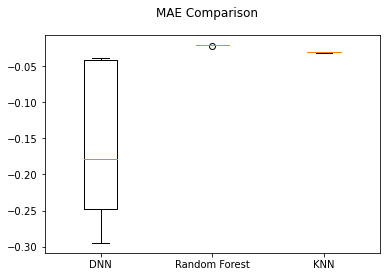

In [57]:
results = []
names = []


for (name, score) in MAE:
    names.append(name)
    msg = "%s: %f (%f)" % (name, score.mean(), score.std())
    results.append(score)
    print(msg)
    

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('MAE Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()



DNN: -0.059399 (0.068750)
Random Forest: -0.001314 (0.000137)
KNN: -0.002491 (0.000131)


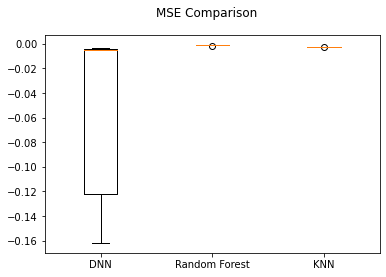

In [56]:
results = []
names = []

for (name, score) in MSE:
    names.append(name)
    msg = "%s: %f (%f)" % (name, score.mean(), score.std())
    results.append(score)
    print(msg)
    

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('MSE Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

DNN: -0.303670 (0.188309)
Random Forest: -0.036170 (0.001856)
KNN: -0.049894 (0.001331)


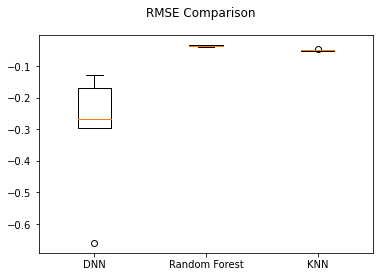

In [47]:
results = []
names = []

for (name, score) in RMSE:
    names.append(name)
    msg = "%s: %f (%f)" % (name, score.mean(), score.std())
    results.append(score)
    print(msg)
    

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

DNN: -10.110053 (10.371381)
Random Forest: 0.743689 (0.024475)
KNN: 0.514928 (0.025135)


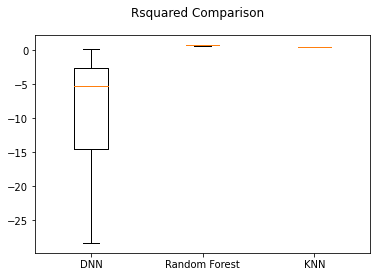

In [46]:
results = []
names = []

for (name, score) in rsquared:
    names.append(name)
    msg = "%s: %f (%f)" % (name, score.mean(), score.std())
    results.append(score)
    print(msg)
    

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Rsquared Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [3]:
#to reload trained models

import joblib
knngrid = joblib.load('KNNgridregressor.pkl')
rf_random = joblib.load('Randomforestregressor.pkl')
search_resultReg = joblib.load( 'DNNregressor.pkl')